In [71]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from pathlib import Path
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

### 1) Perform some EDA

In [72]:
dir = r"C:\Users\tnaga\Documents\MMA\Winter 2023 - 1\INSY695_Enterprise_DS\Goodreads_Book_Recommendation\Modelling"
os.chdir(dir)

In [73]:
df_users = pd.read_csv("../Data/Data_Final/user_details.csv")
df_book_users = pd.read_csv("../Data/Data_Final/bookshelves.csv")

In [74]:
df_books = pd.read_csv("../Data/Data_Final/all_books.csv")

In [75]:
df_books_tmp = pd.merge(df_books, df_book_users, left_on="book_id", right_on="BOOKID", how="inner") # no missing books to users
df_tmp = pd.merge(df_books_tmp, df_users, on="USERID", how="inner") # some books have not been read by users

In [76]:
book_counts = df_tmp.groupby("BOOKID").size()
book_counts.name = "Book_Counts"

In [77]:
df = pd.merge(df_books, book_counts, left_on="book_id", right_index=True, how="left")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274233 entries, 0 to 274232
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   url            274233 non-null  object 
 1   book_pages     274233 non-null  object 
 2   num_of_rating  274233 non-null  int64  
 3   num_of_review  274233 non-null  int64  
 4   genre          274233 non-null  object 
 5   publish        274233 non-null  object 
 6   author         274231 non-null  object 
 7   title          274233 non-null  object 
 8   rating         274233 non-null  float64
 9   award          274233 non-null  object 
 10  isbn           274233 non-null  object 
 11  book_id        274233 non-null  int64  
 12  Book_Counts    259654 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 27.2+ MB


In [300]:
df.describe()

,num_of_rating,num_of_review,rating,book_id,Book_Counts
count,274233.000000,274233.000000,274233.000000,2.742330e+05,259654.000000
mean,166.446161,148.208669,3.995653,2.943557e+07,2.393127
std,246.932018,208.624871,0.333503,2.084824e+07,8.546407
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000
25%,4.000000,12.000000,3.800000,1.015514e+07,1.000000
50%,34.000000,57.000000,4.020000,2.875782e+07,1.000000
75%,236.000000,190.000000,4.220000,4.992890e+07,2.000000
max,999.000000,999.000000,5.000000,9.720231e+07,638.000000


In [301]:
df.isnull().sum()

url                  0
book_pages           0
num_of_rating        0
num_of_review        0
genre                0
publish              0
author               2
title                0
rating               0
award                0
isbn                 0
book_id              0
Book_Counts      14579
dtype: int64

In [302]:
# check percentage of nulls
(df.isnull().sum() / df.shape[0]) * 100

url              0.000000
book_pages       0.000000
num_of_rating    0.000000
num_of_review    0.000000
genre            0.000000
publish          0.000000
author           0.000729
title            0.000000
rating           0.000000
award            0.000000
isbn             0.000000
book_id          0.000000
Book_Counts      5.316282
dtype: float64

In [303]:
df['isbn'] = df['isbn'].astype(str)

In [304]:
# Not very much correlation in the dataset
df.corr()

C:\Users\tnaga\AppData\Local\Temp\ipykernel_29848\306365476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,num_of_rating,num_of_review,rating,book_id,Book_Counts
num_of_rating,1.000000,-0.236052,0.019059,0.075025,-0.008644
num_of_review,-0.236052,1.000000,-0.022975,-0.037285,-0.020902
rating,0.019059,-0.022975,1.000000,0.231202,0.024309
book_id,0.075025,-0.037285,0.231202,1.000000,-0.016157
Book_Counts,-0.008644,-0.020902,0.024309,-0.016157,1.000000


array([[<AxesSubplot: xlabel='num_of_rating', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='rating', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='book_id', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='Book_Counts', ylabel='num_of_rating'>],
       [<AxesSubplot: xlabel='num_of_rating', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='rating', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='book_id', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='Book_Counts', ylabel='num_of_review'>],
       [<AxesSubplot: xlabel='num_of_rating', ylabel='rating'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='rating'>,
        <AxesSubplot: xlabel='rating', ylabel='rating'>,
        <AxesSubplot: xlabel='book_id', ylabel='rating'>,
        <AxesSubplot: xlabel='Book_Counts', ylabel='rating'>],
       [<Axe

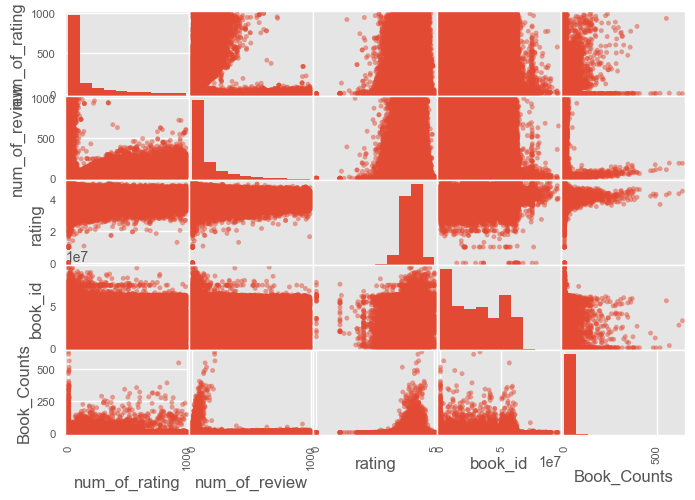

In [305]:
# make num ratings and num reviews on a log scale
scatter_matrix(df)

### 2a) Data Transformation

In [78]:
# missing book counts means that no user has read the book
df['Book_Counts'] = df['Book_Counts'].replace({np.nan: 0})

In [79]:
# remove unique identifiers/unnecessary column
df = df.dropna(how="any")
df_store = df[["isbn", "book_id", "genre", "author", "title"]]
df = df.drop(columns=["url", "isbn", "book_id", "title"])

In [80]:
# split punlish into year month day columns from string
df_date = df['publish'].str.replace("First published ","").str.replace("Published ", "").str.replace("Expected ", "").str.replace("publication ", "").str.split(" ", expand=True)

In [81]:
# Get Dates
df_date.columns = ["Month", "Day", "Year"]
df["year"] = df_date["Year"].astype(int)

df = df.drop(columns="publish")

In [82]:
# Get Genre Counts Frequency Encoded
df_genre_counts = df["genre"].value_counts()
df['genre_freq'] = df['genre'].map(df_genre_counts) / df.shape[0]
df = df.drop(columns="genre")

In [83]:
# Get Author Counts Frequency Encoded
df_author_counts = df["author"].value_counts()
df['author_freq'] = df['author'].map(df_author_counts) / df.shape[0]
df = df.drop(columns="author")

In [84]:
# get number of pages and add a field if the value is missing or not
df_books = df["book_pages"].str.replace(",", "").str.split(" ", expand=True)

non_nums =[]
for item in df_books[0].unique():
    try:
        int(item)
    except:
        non_nums.append(item)

df["pages"] = df_books[0].replace(non_nums, np.nan).astype(float) 
df["page_missing"] = [1 if val is np.nan else 0 for val in df["pages"]]

df = df.drop(columns="book_pages")

(array([3.43000e+02, 2.18700e+03, 1.40610e+04, 8.14560e+04, 1.51894e+05,
        1.84700e+03, 5.10000e+01, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.        ,  1.37590217,  2.75180434,  4.12770651,  5.50360867,
         6.87951084,  8.25541301,  9.63131518, 11.00721735, 12.38311952,
        13.75902168]),
 <BarContainer object of 10 artists>)

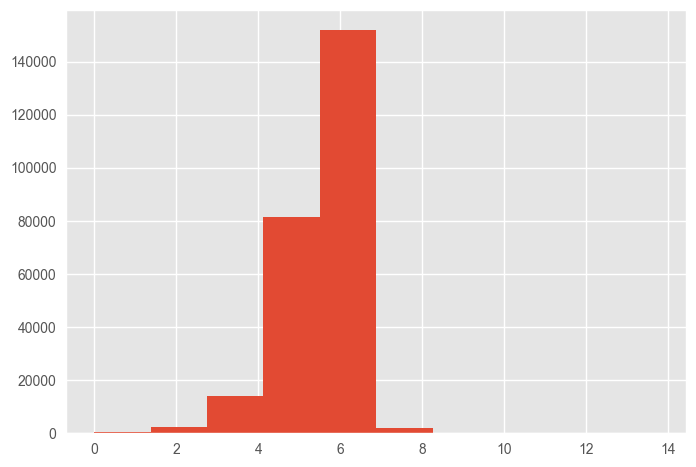

In [85]:
plt.hist(np.log(df["pages"]))

In [86]:
# create pipeline to do imputation using median
# one hot encoding of categorial variables
# and power transformation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
min_max_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", MinMaxScaler()),
])
one_cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop='first')),
])
pow_num_pipeline = Pipeline([
    ("impute", IterativeImputer(initial_strategy="median")),
    ("log", PowerTransformer()),
    ("standardize", StandardScaler()),
])

In [87]:
num_attrs = ['rating']
min_max_attrs = ['genre_freq', 'author_freq', 'year']
one_cat_attrs = ['award', 'page_missing']
pow_num_attrs = ['num_of_rating', 'num_of_review', 'pages', 'Book_Counts']

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("min_max", min_max_pipeline, min_max_attrs),
    ("one_cat", one_cat_pipeline, one_cat_attrs),
    ("pow_num", pow_num_pipeline, pow_num_attrs)
], sparse_threshold=0)

In [88]:
# run pipeline on training and testing data
df_prepared = preprocessing.fit_transform(df)

In [89]:
df_prep = pd.DataFrame(
    df_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=df.index)

In [90]:
df_prep.head()

,num__rating,min_max__genre_freq,min_max__author_freq,min_max__year,one_cat__award_[1],pow_num__num_of_rating,pow_num__num_of_review,pow_num__pages,pow_num__Book_Counts
0,0.402832,0.004808,0.000000,0.083927,0.0,-0.343204,-1.381449,2.136930,-0.333953
1,0.492786,0.433705,0.025316,0.086142,0.0,0.382088,-1.515747,-0.068718,2.218332
2,1.902066,0.000000,0.001582,0.087663,0.0,-0.659144,-1.515747,0.722862,-0.333953
3,0.822618,0.009246,0.000000,0.087402,0.0,-1.418880,0.514127,0.233070,-0.333953
4,-2.805527,0.000647,0.001582,0.085534,0.0,-0.343204,-1.515747,-0.501284,-0.333953


In [91]:
df_prep.columns = ['rating', 'genre_freq', 'author_freq', 'year', 'award', 'num_ratings', 'num_reviews', 'num_pages', 'book_counts']

In [92]:
df_prep.corr()

,rating,genre_freq,author_freq,year,award,num_ratings,num_reviews,num_pages,book_counts
rating,1.000000,-0.049373,0.068806,0.035815,-0.016934,0.016381,0.028755,0.124428,0.048745
genre_freq,-0.049373,1.000000,0.165663,-0.023362,0.116990,-0.054038,0.054910,0.153252,0.078822
author_freq,0.068806,0.165663,1.000000,-0.044913,0.105684,-0.029212,-0.036892,0.047678,0.114999
year,0.035815,-0.023362,-0.044913,1.000000,-0.008367,0.007419,0.025437,0.009044,0.017411
award,-0.016934,0.116990,0.105684,-0.008367,1.000000,-0.023652,-0.103627,0.138036,0.115083
num_ratings,0.016381,-0.054038,-0.029212,0.007419,-0.023652,1.000000,-0.327824,-0.074692,-0.099246
num_reviews,0.028755,0.054910,-0.036892,0.025437,-0.103627,-0.327824,1.000000,0.044380,0.010571
num_pages,0.124428,0.153252,0.047678,0.009044,0.138036,-0.074692,0.044380,1.000000,0.095059
book_counts,0.048745,0.078822,0.114999,0.017411,0.115083,-0.099246,0.010571,0.095059,1.000000


In [93]:
# Outlier removal
# isolation_forest = IsolationForest(random_state=42)
# outlier_pred = isolation_forest.fit_predict(df_prep)
# df_prep_out = df_prep.iloc[outlier_pred == 1]
# df_store = df_store.iloc[outlier_pred == 1]
df_prep_out = df_prep.drop(columns='book_counts')
df_prep_out = df_prep_out.drop_duplicates()

#### Find the duplicates in the dataset

In [56]:
idx = df_prep_out.duplicated().values

In [358]:
tmp = df_prep_out.loc[idx,:]

In [359]:
tmp_books = pd.merge(tmp, df_store, left_index = True, right_index = True, how = "inner")

In [361]:
tmp_books["book_id"].to_csv("duplicates.csv")

### 3) Model Testing

#### KMeans

In [27]:
# from sklearn.cluster import KMeans
# inertia = []
# for i in range(5,20):
#     km = KMeans(n_clusters = i, n_init=10, random_state=42)
#     model = km.fit(df_prep_out)
#     print(model.inertia_)
#     inertia.append(model.inertia_)
#     labels = model.labels_

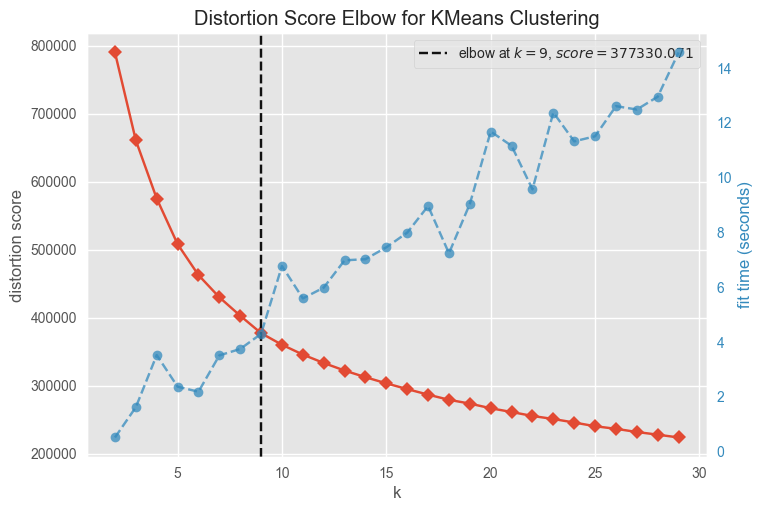

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [94]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(n_init=10, random_state=42)
vis = KElbowVisualizer(km, k=(2,30))

vis.fit(df_prep_out)
vis.show()

c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



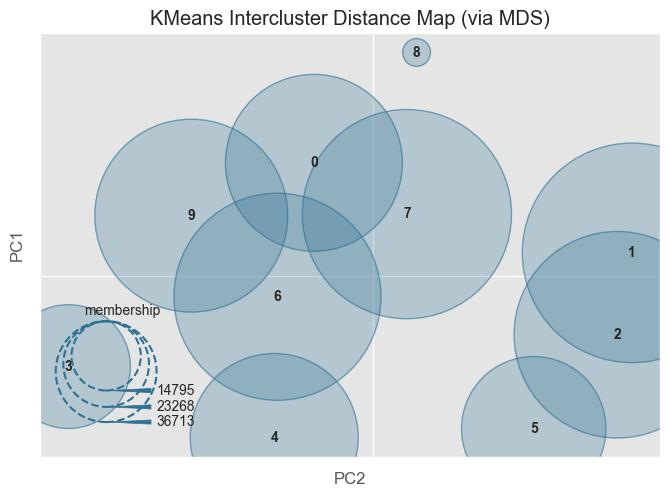

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [95]:
from yellowbrick.cluster.icdm import InterclusterDistance
km = KMeans(n_clusters=10, n_init=10, random_state=42)
vis_clust = InterclusterDistance(km)
vis_clust.fit(df_prep_out)
vis_clust.show()

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_prep_out.shape[1]-1)
X_PCA = pca.fit_transform(df_prep_out)
df_PCA = pd.DataFrame(X_PCA, columns = [f"PC{i}" for i in range(1,len(df_prep_out.columns))])

df_components = pd.DataFrame(pca.components_, columns=df_prep_out.columns)
df_components = df_components.T
df_components.columns = [f"PC{i}" for i in range(1,len(df_prep_out.columns))]


In [97]:
pca.explained_variance_ratio_.round(2)

array([0.32, 0.26, 0.21, 0.16, 0.03, 0.02, 0.  ])

In [98]:
df_PCA.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.034054,1.786062,1.550455,-1.041853,0.467793,0.203442,-0.035086
1,-1.198759,0.704948,-0.043156,-0.862237,0.111999,-0.259738,-0.029121
2,-0.075110,1.966572,-0.419459,-1.688975,0.340841,0.132002,-0.046008
3,1.471582,0.311376,-0.489619,-0.711065,0.271099,0.200041,-0.034778
4,-1.292169,-2.143040,1.796465,-0.999526,0.358648,0.183262,-0.013795


In [99]:
df_components.round(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
rating,0.13,0.73,-0.66,-0.13,-0.03,-0.02,-0.01
genre_freq,0.03,0.01,0.06,0.01,-0.40,-0.91,-0.05
author_freq,0.00,0.01,-0.00,-0.01,-0.04,-0.03,1.00
year,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00
award,0.00,0.03,0.06,-0.05,-0.91,0.41,-0.02
num_ratings,-0.68,0.24,-0.01,0.69,-0.03,0.00,0.00
num_reviews,0.65,-0.19,-0.21,0.70,-0.04,0.04,0.00
num_pages,0.31,0.61,0.72,0.10,0.07,0.03,0.00


In [100]:
fitted = km.fit(df_prep_out)
labels = fitted.labels_
centers = fitted.cluster_centers_

In [101]:
pca_centers = pca.transform(centers)

df_centers = pd.DataFrame(pca_centers, columns=[f"PC{i}" for i in range(1,len(df_prep_out.columns))])

c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [102]:
df_centers

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.607930,1.002423,-0.179779,-0.944171,0.014279,0.032361,-0.006856
1,1.554162,0.304919,-0.349605,-0.142609,0.027317,-0.010609,0.004518
2,1.471134,-0.809552,0.484868,0.157595,-0.037865,-0.005274,-0.002831
3,-1.231086,-1.795098,1.167177,-0.029915,0.151111,0.040143,-0.002922
4,-1.411152,-0.938593,-1.274932,-0.104323,-0.032315,-0.002994,0.001200
5,0.893152,-1.289067,-1.126132,-0.346906,-0.061906,-0.005931,0.026307
6,-0.822566,-0.105646,0.454852,0.895310,0.017316,-0.009064,-0.011131
7,-0.633780,0.953372,-0.584669,0.610210,0.058836,-0.003104,-0.010840
8,-0.006045,2.101536,1.259189,0.130641,-0.092104,0.038265,0.038304
9,-0.814439,0.074584,0.874070,-0.910298,-0.083212,-0.009555,0.006146


(-9.860352016429067, 10.2)

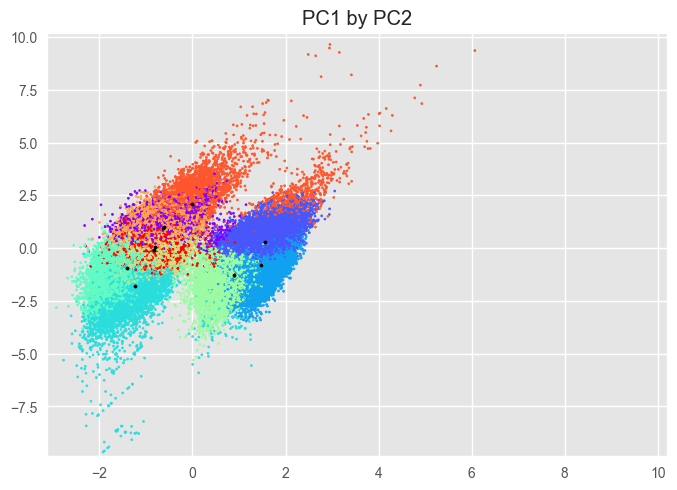

In [103]:
pc1 = 1
pc2 = 2

pcs = [f"PC{i}" for i in range(1,len(df_prep_out.columns))]
plt.style.use('ggplot')
plt.scatter(df_PCA[pcs[pc1-1]], df_PCA[pcs[pc2-1]], c=labels, cmap='rainbow', s=2)
plt.scatter(df_centers[pcs[pc1-1]], df_centers[pcs[pc2-1]], c='black', s=5)
plt.title(f"{pcs[pc1-1]} by {pcs[pc2-1]}")
plt.xlim((max(df_PCA[pcs[pc1-1]].min(), -10) - 0.2, min(df_PCA[pcs[pc1-1]].max(), 10) + 0.2))
plt.ylim((max(df_PCA[pcs[pc2-1]].min(), -10) - 0.2, min(df_PCA[pcs[pc2-1]].max(), 10) + 0.2))

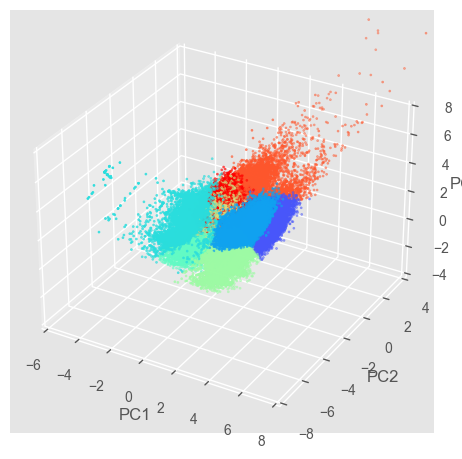

In [104]:
pc1 = 1
pc2 = 2
pc3 = 3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df_PCA[pcs[pc1-1]], df_PCA[pcs[pc2-1]], df_PCA[pcs[pc3-1]], c=labels, cmap='rainbow', s=2)
ax.scatter(df_centers[pcs[pc1-1]], df_centers[pcs[pc2-1]], df_centers[pcs[pc3-1]], c='black', s=9)

ax.set_xlim((-6,8))
ax.set_ylim((-8,4))
ax.set_zlim((-4,8))
ax.set_xlabel(f"PC{pc1}")
ax.set_ylabel(f"PC{pc2}")
ax.set_zlabel(f"PC{pc3}")

plt.show()

In [105]:
pc1 = 1
pc2 = 2
pc3 = 3

df = pd.concat([df_PCA, pd.Series(labels, name="Labels")], axis=1)
df.head()
import plotly.express as px
fig = px.scatter_3d(df.sample(10000), x=f"PC{pc1}", y=f"PC{pc2}", z=f"PC{pc3}",
              color='Labels', range_x=[-6,8], range_y=[-8,4], range_z=[-4,8])

fig.show(renderer="browser")

### 4) For each user get top clusters to recommend

In [188]:
df_users = pd.read_csv("../Data/Data_Final/user_details.csv")
df_book_users = pd.read_csv("../Data/Data_Final/bookshelves.csv")

In [189]:
labels = fitted.labels_

In [190]:
df_books = pd.concat([df_prep_out, df_store["book_id"], pd.Series(labels, name="Label")], axis=1)
df_books = pd.merge(df_books, book_counts, left_on='book_id', right_index=True)
df_books['Book_Counts'] = df_books['Book_Counts'].replace({np.nan: 0})

In [191]:
df_books_tmp = pd.merge(df_books, df_book_users, left_on="book_id", right_on="BOOKID", how="inner") # no missing books to users
df_all = pd.merge(df_books_tmp, df_users, on="USERID", how="inner") # some books have not been read by users
user_list = df_all["USERID"].tolist()
df_all = df_all.drop(columns=["BOOKID", "age", "gender", "Country", "Book_Counts"])

#### subset for users

In [230]:
user = user_list[9]
df_test = df_all.loc[df_all['USERID'] == user,:]
read_book_ids = df_test['book_id'].to_list()
df_test = df_test.drop(columns=["USERID", "Label", "book_id"])
df_test = df_test.dropna(how="any")
# X_train, X_test = train_test_split(df_test, test_size = 0.3, random_state=42)
# read_book_ids = X_train['book_id'].to_list()
# test_read_book_ids = X_test['book_id'].to_list()
# X_train = X_train.drop(columns=["USERID", "Label", "book_id"])
# X_train = X_train.dropna(how="any")
# X_test = X_test.drop(columns=["USERID", "Label", "book_id"])
# X_test = X_test.dropna(how="any")

In [231]:
preds = km.predict(df_test)
# preds = km.predict(X_train)
# test_preds = km.predict(X_test)

In [232]:
num_topics = {}
for book in preds:
    if str(book) not in num_topics.keys():
        num_topics[str(book)] = 1
    else:
        num_topics[str(book)] += 1

total = 0
for key in num_topics.keys():
    num_topics[key] = round(num_topics[key] / len(preds) * 20)
    total += num_topics[key]

if total < 20:
    max_key = max(num_topics, key=num_topics.get)
    num_topics[max_key] += 1
elif total > 20:
    min_key = max(num_topics, key=num_topics.get)
    num_topics[min_key] -= 1


In [233]:
recommendations = []
for key in num_topics.keys():
    df_books_sub = df_books.loc[df_books["Label"] == int(key),:]
    df_books_sub = df_books_sub.loc[~(df_books_sub['book_id'].isin(read_book_ids)),:]

    total = 0
    for num in df_books_sub["Book_Counts"]:
        total += num
    df_books_sub['Book_Counts'] = df_books_sub['Book_Counts'] / total

    df_books_sub = df_books_sub.sort_values(by="Book_Counts", ascending=False).reset_index(drop=True)

    recommendations.extend(df_books_sub.loc[:num_topics[key]-1, "book_id"])

idx = df_books[df_books['book_id'].isin(recommendations)].index

In [234]:
book_recs = df_store.loc[idx,:]
read_books = df_store.loc[df_store['book_id'].isin(read_book_ids)]
test_read_books = df_store.loc[df_store['book_id'].isin(test_read_book_ids)]

In [235]:
read_books.head(30)

,isbn,book_id,genre,author,title
5496,['9780375507250'],49628,Science Fiction,David Mitchell,Cloud Atlas
7170,['9780060566227'],150037,Young Adult,Lemony Snicket,The Vile Village
12196,['9780440227533'],47281,Young Adult,Lois Lowry,Number the Stars
18136,['9780451528827'],8127,Fiction,L.M. Montgomery,Anne of Green Gables
23904,['9780486264660'],752629,Classics,Emily Dickinson,Selected Poems
23907,['9780063095724'],56755560,Fiction,Sōsuke Natsukawa,The Cat Who Saved Books
24427,['9780064410144'],65111,Young Adult,Lemony Snicket,The Grim Grotto
26815,['NA'],78418,Young Adult,Lemony Snicket,The Reptile Room
31932,['NA'],15818107,Fiction,Christina Baker Kline,Orphan Train
33503,['9780805092431'],8051458,Horror,Alden Bell,The Reapers are the Angels


In [236]:
book_recs

,isbn,book_id,genre,author,title
3393,['9780553588484'],13496,Fiction,George R.R. Martin,A Game of Thrones
34989,['NA'],1885,Fiction,Jane Austen,Pride and Prejudice
94204,['9781538724743'],59344312,Romance,Colleen Hoover,Verity
140505,['9780593336823'],56732449,Contemporary,Ali Hazelwood,The Love Hypothesis
158552,['NA'],27362503,Fiction,Colleen Hoover,It Ends with Us
212485,['NA'],2,Young Adult,J.K. Rowling,Harry Potter and the Order of the Phoenix
216459,['9781501110344'],25111004,Contemporary,Colleen Hoover,09-Nov
224466,['9780316556347'],35959740,Fiction,Madeline Miller,Circe
36453,['NA'],6,Young Adult,J.K. Rowling,Harry Potter and the Goblet of Fire
112789,['9780735219113'],36809135,Historical Fiction,Delia Owens,Where the Crawdads Sing


In [229]:
test_read_books

,isbn,book_id,genre,author,title
0,['NA'],61316653,non-fiction,Petrona C. de Gandulfo,El libro de Dona Petrona
12859,['9781400064168'],8664353,History,Laura Hillenbrand,"Unbroken: A World War II Story of Survival, Re..."
27965,['9781933929699'],2943370,Fiction,Mykle Hansen,HELP! A Bear is Eating Me!
28918,['9789707311169'],56919,Classics,Mario Benedetti,La tregua
30200,['9781250163516'],43263220,Animals,W. Bruce Cameron,A Dog's Promise
32151,['9780061120664'],6882,Biography,Henri Charrière,Papillon
34474,['9780062200570'],15729539,Fiction,Joe Hill,NOS4A2
44959,['NA'],100915,Classics,C.S. Lewis,"The Lion, the Witch and the Wardrobe"
67242,['9780440940005'],563040,Fiction,Scott O'Dell,Island of the Blue Dolphins
78469,['9780439272636'],65119,Young Adult,Lemony Snicket,The Miserable Mill


#### Visualize books

In [272]:
# transform predicted books
df_prep_preds = pd.concat([df_prep_out, df_store['book_id']], axis = 1)
df_prep_preds = df_prep_preds[df_prep_preds['book_id'].isin(book_recs['book_id'])]
df_prep_preds = df_prep_preds.drop(columns="book_id")
pca_preds = pca.transform(df_prep_preds)
df_pca_preds = pd.DataFrame(pca_preds, columns=[f"PC{i}" for i in range(1,len(df_prep_preds.columns))])

In [273]:
# transform read books
pca_test = pca.transform(df_test)
df_pca_test = pd.DataFrame(pca_test, columns=[f"PC{i}" for i in range(1,len(df_test.columns))])

In [274]:
num_topics

{'8': 3, '1': 2, '3': 3, '0': 4, '2': 1, '7': 3, '4': 1, '6': 2, '5': 1}

(-2.0933405122852204, 3.3847623653352197)

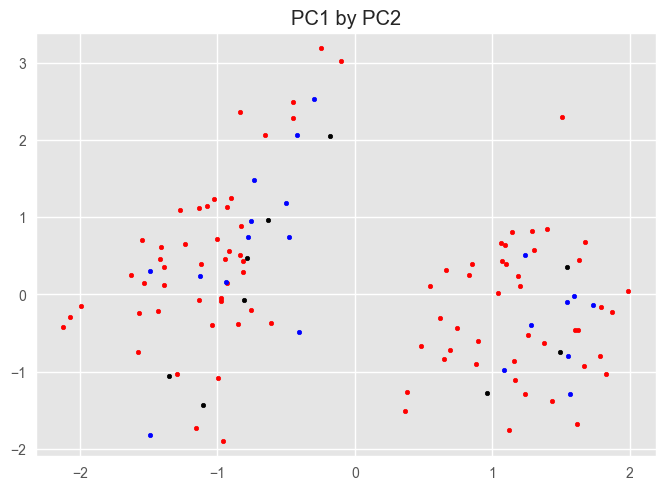

In [275]:
pc1 = 1
pc2 = 2

pcs = [f"PC{i}" for i in range(1,len(df_test.columns))]
plt.style.use('ggplot')
plt.scatter(df_pca_test[pcs[pc1-1]], df_pca_test[pcs[pc2-1]], c='red', s=10)
plt.scatter(df_centers[pcs[pc1-1]], df_centers[pcs[pc2-1]], c='black', s=10)
plt.scatter(df_pca_preds[pcs[pc1-1]], df_pca_preds[pcs[pc2-1]], c='blue', s=10)
plt.title(f"{pcs[pc1-1]} by {pcs[pc2-1]}")
plt.xlim((max(df_pca_test[pcs[pc1-1]].min(), -10) - 0.2, min(df_pca_test[pcs[pc1-1]].max(), 10) + 0.2))
plt.ylim((max(df_pca_test[pcs[pc2-1]].min(), -10) - 0.2, min(df_pca_test[pcs[pc2-1]].max(), 10) + 0.2))

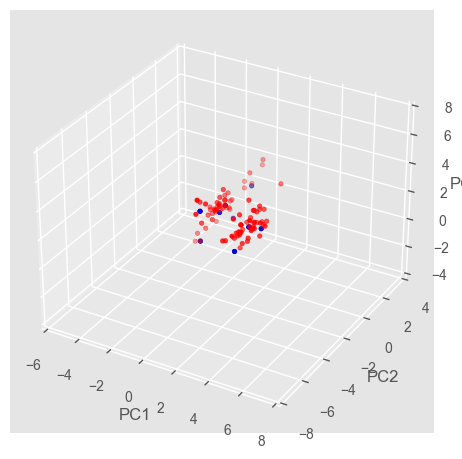

In [276]:
pc1 = 1
pc2 = 2
pc3 = 3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df_pca_test[pcs[pc1-1]], df_pca_test[pcs[pc2-1]], df_pca_test[pcs[pc3-1]], c="red", s=10)
ax.scatter(df_centers[pcs[pc1-1]], df_centers[pcs[pc2-1]], df_centers[pcs[pc3-1]], c='black', s=10)
ax.scatter(df_centers[pcs[pc1-1]], df_centers[pcs[pc2-1]], df_centers[pcs[pc3-1]], c='blue', s=10)

ax.set_xlim((-6,8))
ax.set_ylim((-8,4))
ax.set_zlim((-4,8))
ax.set_xlabel(f"PC{pc1}")
ax.set_ylabel(f"PC{pc2}")
ax.set_zlabel(f"PC{pc3}")

plt.show()

### 6) Prediction of Number of Books - Regression Model

**All of below is pretty bad imo and it's not predicting number of books well**

In [135]:
df_reg = pd.concat([df_prep, df_store['book_id']], axis = 1)
df_reg = df_reg.drop(columns="book_counts")

In [136]:
df_reg_tmp = pd.merge(df_reg, df_book_users, left_on="book_id", right_on="BOOKID", how="inner") # no missing books to users
df_reg_tmp = pd.merge(df_reg_tmp, df_users, on="USERID", how="inner") # some books have not been read by users
df_reg_tmp = df_reg_tmp.drop(columns = "book_id")

In [137]:
book_counts = df_reg_tmp.groupby("BOOKID").size()
book_counts.name = "Book_Counts"

In [138]:
df_prep

,rating,genre_freq,author_freq,year,award,num_ratings,num_reviews,num_pages,book_counts
0,0.402832,0.004808,0.000000,0.083927,0.0,-0.343204,-1.381449,2.136930,-0.333953
1,0.492786,0.433705,0.025316,0.086142,0.0,0.382088,-1.515747,-0.068718,2.218332
2,1.902066,0.000000,0.001582,0.087663,0.0,-0.659144,-1.515747,0.722862,-0.333953
3,0.822618,0.009246,0.000000,0.087402,0.0,-1.418880,0.514127,0.233070,-0.333953
4,-2.805527,0.000647,0.001582,0.085534,0.0,-0.343204,-1.515747,-0.501284,-0.333953
...,...,...,...,...,...,...,...,...,...
274228,-0.346784,0.111971,0.033228,0.084361,0.0,1.067595,-0.757300,2.056706,-0.333953
274229,0.852602,1.000000,0.012658,0.087185,1.0,0.678684,-0.757300,0.266378,-0.333953
274230,-0.856524,0.081212,0.049051,0.087446,0.0,1.020282,-0.540822,0.158072,-0.333953
274231,-0.106907,1.000000,0.094937,0.081364,0.0,0.698895,-1.044234,0.855693,-0.333953


In [139]:
df_prep_books = pd.merge(df_reg, book_counts, how="left", left_on="book_id", right_index=True)

In [140]:
df_prep_books.head()

,rating,genre_freq,author_freq,year,award,num_ratings,num_reviews,num_pages,book_id,Book_Counts
0,0.402832,0.004808,0.000000,0.083927,0.0,-0.343204,-1.381449,2.136930,61316653,1.0
1,0.492786,0.433705,0.025316,0.086142,0.0,0.382088,-1.515747,-0.068718,129603,9.0
2,1.902066,0.000000,0.001582,0.087663,0.0,-0.659144,-1.515747,0.722862,51091831,1.0
3,0.822618,0.009246,0.000000,0.087402,0.0,-1.418880,0.514127,0.233070,15818223,1.0
4,-2.805527,0.000647,0.001582,0.085534,0.0,-0.343204,-1.515747,-0.501284,5949533,1.0


In [141]:
df_prep_books['Book_Counts'] = df_prep_books['Book_Counts'].replace({np.nan: 0})

In [277]:
df_prep_books['Book_Counts'] = df_prep_books['Book_Counts'] + 1
df_prep_books['Book_Counts'] = df_prep_books['Book_Counts'].apply(lambda x: np.log(x))

In [278]:
y = df_prep_books["Book_Counts"]
X = df_prep_books.drop(columns="Book_Counts")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [279]:
# Outlier removal
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X_train)

In [280]:
X_train = X_train.iloc[outlier_pred == 1]
y_train = y_train.iloc[outlier_pred == 1]

In [281]:
X_train.shape

(190419, 9)

In [282]:
from sklearn.neural_network import MLPRegressor

model_lm = LinearRegression()
model_rf = RandomForestRegressor()
model_gb = GradientBoostingRegressor()
model_ad = AdaBoostRegressor()
model_mp = MLPRegressor()

In [283]:
from sklearn.neural_network import MLPRegressor

model_lm = LinearRegression()
model_rf = RandomForestRegressor()
model_gb = GradientBoostingRegressor()
model_ad = AdaBoostRegressor()
model_mp = MLPRegressor()

lm_mse = -cross_val_score(model_lm, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rf_mse = -cross_val_score(model_rf, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
gb_mse = -cross_val_score(model_gb, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
ad_mse = -cross_val_score(model_ad, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
mp_mse = -cross_val_score(model_ad, X_train, y_train, scoring="neg_mean_squared_error", cv=5)

In [284]:
# Gradient Boosting gives best predictions with base predictions
print(f"Linear Model MSE: {lm_mse.mean()}")
print(f"Random Forest Model MSE: {rf_mse.mean()}")
print(f"Gradient Boosting Model MSE: {gb_mse.mean()}")
print(f"Adaptive Boosting MSE: {ad_mse.mean()}")
print(f"Multilayer-Perceptron MSE: {mp_mse.mean()}")

Linear Model MSE: 0.20666343361790776
Random Forest Model MSE: 0.1771684856815065
Gradient Boosting Model MSE: 0.17768187764131937
Adaptive Boosting MSE: 0.23233454789468136
Multilayer-Perceptron MSE: 0.2254179646610341


In [285]:
model_rf_fit = model_rf.fit(X_train, y_train)

In [286]:
y_preds = model_rf_fit.predict(X_test)

In [287]:
mse = mean_squared_error(y_test, y_preds)

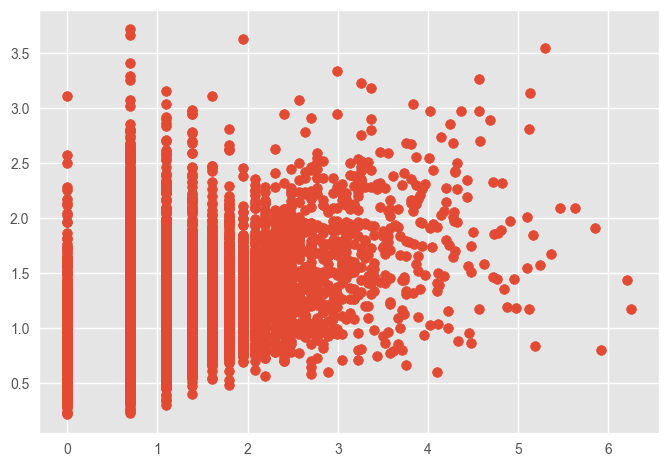

In [288]:
plt.figure()
plt.scatter(y_test, y_preds)

In [180]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50, 100, 200, 300],
    'min_impurity_decrease': [10 ** i for i in range(-5, -1)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]}
    ]
grid_search = GridSearchCV(model_gb, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_*(-1)

In [ ]:
y_preds = best_estimator.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_preds)